In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_labels_latex, topological_category_hatches
from src.signal_categories import filetype_category_labels, filetype_category_colors, filetype_category_hatches
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_labels_latex, del1g_simple_category_colors, del1g_simple_category_hatches
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors, del1g_detailed_category_labels_latex, del1g_detailed_category_hatches

from src.file_locations import intermediate_files_location


# File Loading

In [2]:
#training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"

training = "first_mixed_del1g_iso_training"

sig_category_name = "del1g_simple_signal_category"

if sig_category_name == "del1g_simple_signal_category":
    sig_categories = del1g_simple_category_labels
    sig_category_labels_latex = del1g_simple_category_labels_latex
elif sig_category_name == "del1g_detailed_signal_category":
    sig_categories = del1g_detailed_category_labels
    sig_category_labels_latex = del1g_detailed_category_labels_latex
elif sig_category_name == "topological_signal_category":
    sig_categories = topological_category_labels
    sig_category_labels_latex = topological_category_labels_latex
else:
    raise ValueError(f"Invalid sig_category_name: {sig_category_name}")



In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")


loading all_df.pkl...
all_df.shape=(25186, 249)
loading predictions.pkl...
pred_df.shape=(375264, 23)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.511


In [4]:
print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


merged_df.shape=(1987, 268)
presel_merged_df.shape=(1946, 268)


wc_WCPMTInfoFlashID  wc_WCPMTInfoStrength  \
7                      NaN                   NaN   
21                     NaN                   NaN   
60                     NaN                   NaN   
71                     NaN                   NaN   
83                     NaN                   NaN   
...                    ...                   ...   
23581                 20.0              0.981756   
24343                 15.0              0.900087   
25031                 15.0              0.902192   
25048                 28.0              0.898457   
25054                 18.0              0.906849   

       wc_single_photon_other_score  wc_WCPMTInfoFlashTime  wc_numu_score  \
7                         -2.556328                    NaN      -1.043858   
21                        -1.135650                    NaN      -0.710490   
60                        -0.412643                    NaN       3.305738   
71                        -1.075697                    NaN       1.362073   
83                        -3.781686                    NaN       0.210693   
...                             ...                    ...            ...   
23581                      0.132013               3.640625       2.331077   
24343                      1.554586               5.046875      -1.144554   
25031                     -0.817203               4.781250      -1.510711   
25048                      0.714689               4.203125       2.646901   
25054                      0.463202               4.312500       2.879367   

                                      wc_WCPMTInfoPeMeas  \
7                                                    NaN   
21                                                   NaN   
60                                                   NaN   
71                                                   NaN   
83                                                   NaN   
...                                                  ...   
23581  [0.4928767681121826, 0.0, 2.837269425392151, 1...   
24343  [0.0, 0.0, 0.0, 2.4139976501464844, 1.03663811...   
25031  [1.0249969959259033, 3.972028136253357, 0.0, 7...   
25048  [5.812263131141663, 11.187408313155174, 5.8576...   
25054  [85.59701952338219, 117.8228960186243, 68.8081...   

       wc_shw_sp_n_20br1_showers  wc_nue_score  wc_single_photon_ncpi0_score  \
7                            0.0    -15.000000                      0.272143   
21                           2.0     -4.049474                     -0.462797   
60                           2.0    -12.973451                      0.284562   
71                           1.0     -9.857704                      0.458589   
83                           0.0     -9.418540                      0.529745   
...                          ...           ...                           ...   
23581                        2.0    -10.533014                     -0.271327   
24343                        1.0    -15.000000                      0.004515   
25031                        2.0    -14.675837                     -0.553068   
25048                        1.0    -15.000000                     -0.033292   
25054                        1.0    -15.000000                      0.186292   

       wc_single_photon_nue_score  ...  prob_numuCC1pi0_Np  \
7                       -1.676819  ...            0.001505   
21                      -1.911803  ...            0.002857   
60                      -2.338027  ...            0.009375   
71                      -2.933243  ...            0.032723   
83                      -0.845269  ...            0.001705   
...                           ...  ...                 ...   
23581                   -1.941537  ...            0.003065   
24343                    0.631543  ...            0.152436   
25031                   -0.027408  ...            0.212698   
25048                    0.803118  ...            0.443184   
25054                    1.268913  ...            0.002193   

       prob_numuCC1pi0_0p  pro

In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax

reco_category_queries = []
for i, signal_category in enumerate(sig_categories):
    reco_category_queries.append(f"reco_category_argmax_index == {i}")


/tmp/ipykernel_3202970/980883663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Histograms

/tmp/ipykernel_3202970/641025880.py:78: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[axnum].set_ylim(0, np.max(bottom) * 1.1)


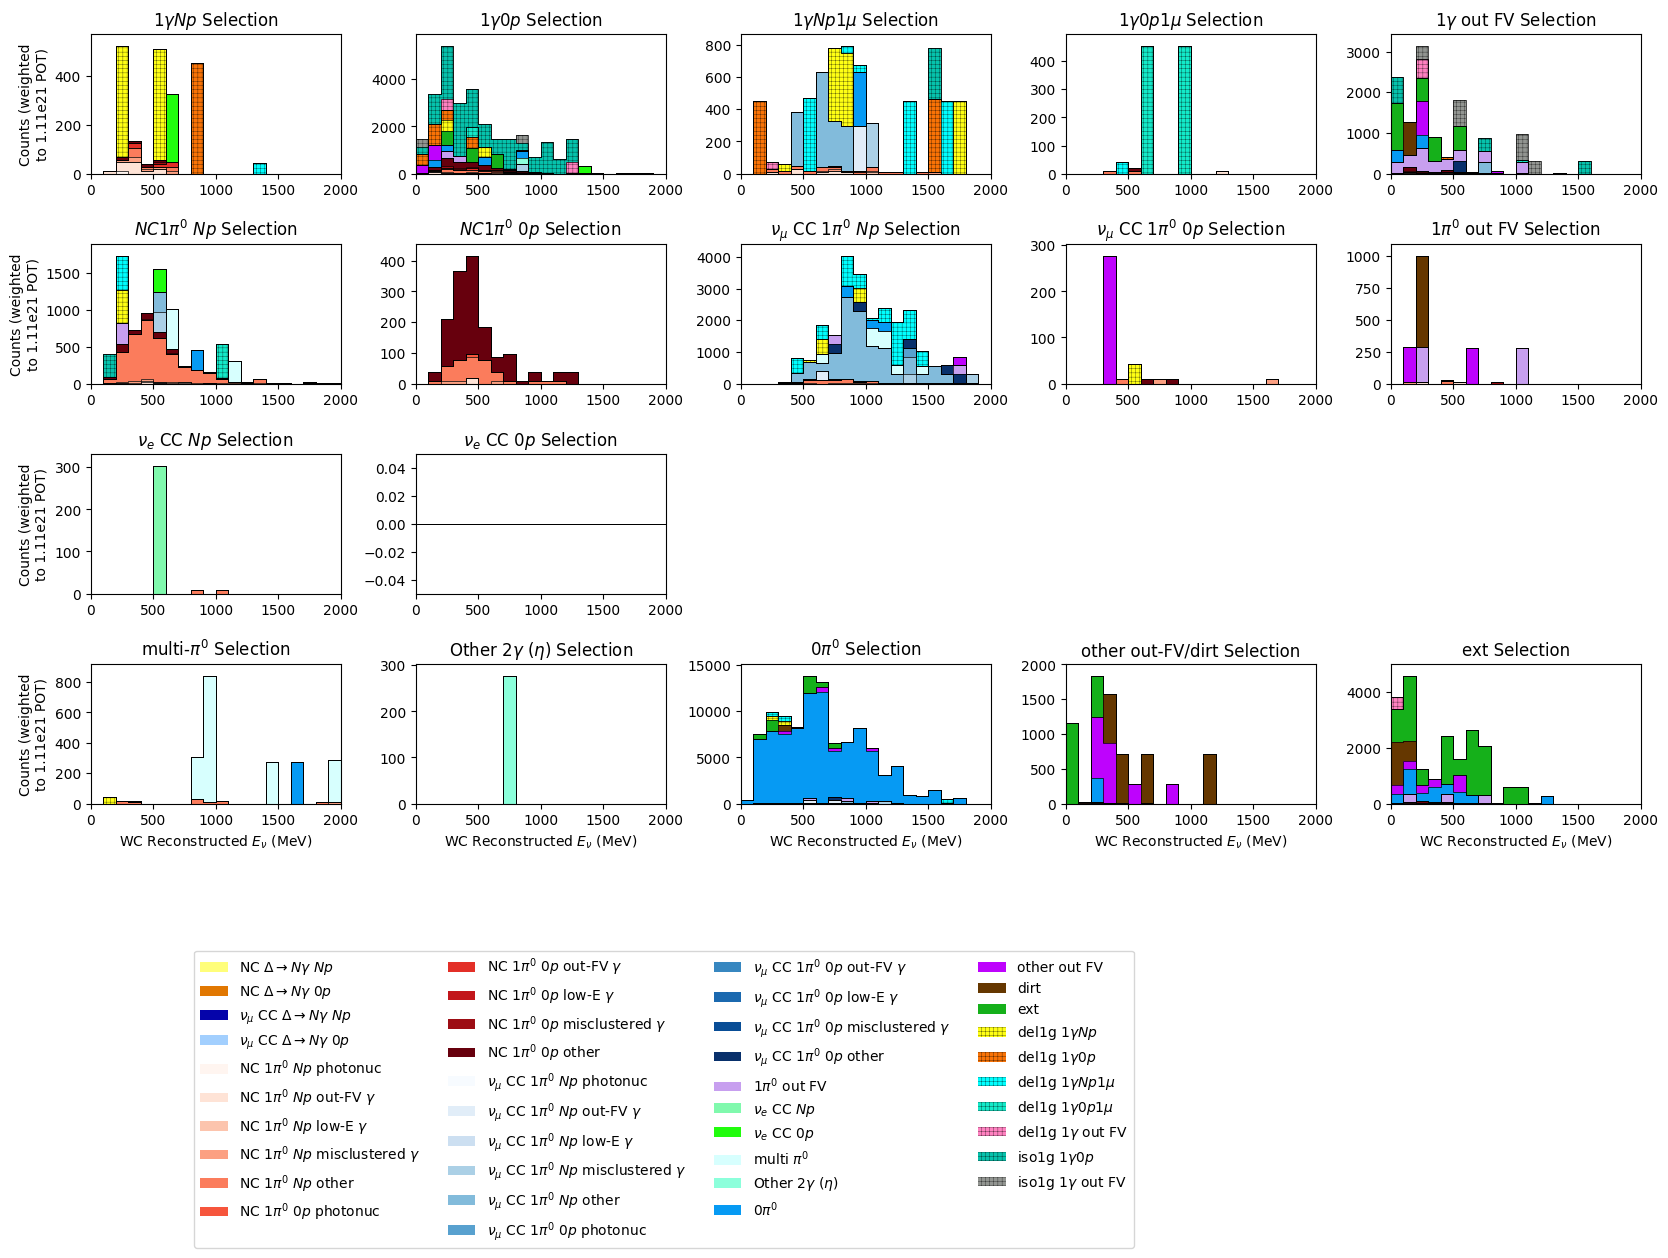

In [6]:
mpl.rcParams['hatch.linewidth'] = 0.2

del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

for breakdown_type in ["del1g_detailed"]: # "topological"  "filetype"
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_labels_latex = topological_category_labels_latex
        breakdown_colors = topological_category_colors
        breakdown_hatches = topological_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_labels_latex = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_hatches = filetype_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_simple":
        breakdown_labels = del1g_simple_category_labels
        breakdown_labels_latex = del1g_simple_category_labels
        breakdown_colors = del1g_simple_category_colors
        breakdown_hatches = del1g_simple_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_simple_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in range(len(sig_categories)):

        signal_category = sig_categories[i]
        signal_category_latex = sig_category_labels_latex[i]

        sel_df = presel_merged_df.query(reco_category_queries[i])

        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])

        axnum = i
        if i >= 12: # background categories, start new row
            axnum = i + 3

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor

            n, _, _ = axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n
        axs[axnum].set_ylim(0, np.max(bottom) * 1.1)

        if axnum in [15, 16, 17, 18, 19]:
            axs[axnum].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if axnum % 5 == 0: # Only show y-label for leftmost column
            axs[axnum].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
        axs[axnum].set_title(f"{signal_category_latex} Selection")
        axs[axnum].set_xlim(0, 2000)

        if axnum == 19:
            axs[axnum].legend(ncol=4, loc='upper right', bbox_to_anchor=(-1, -1))
    
    for axnum in range(20):
        if axnum in [12, 13, 14]:
            axs[axnum].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.png")
    plt.show()


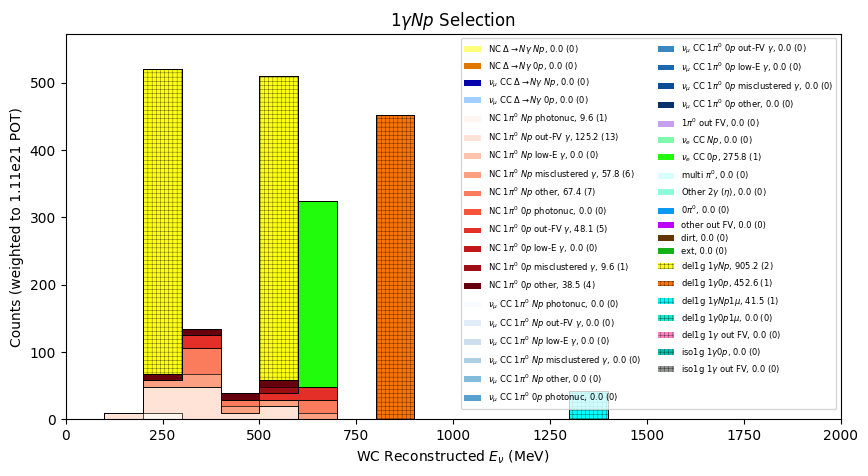

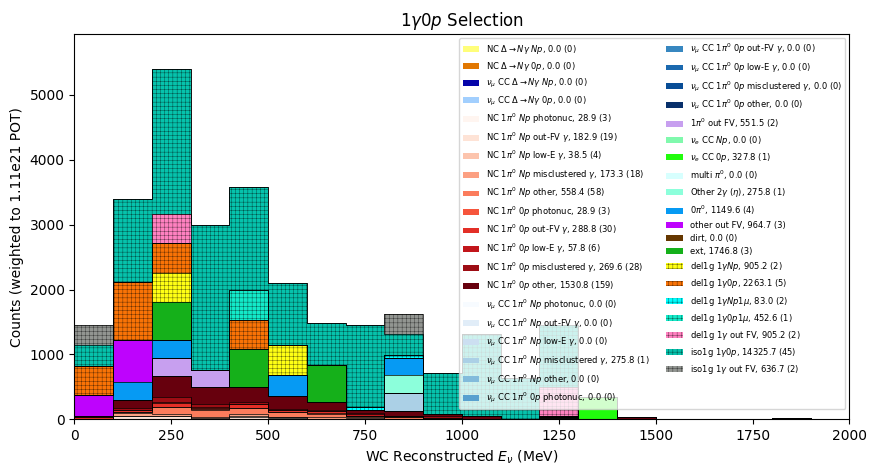

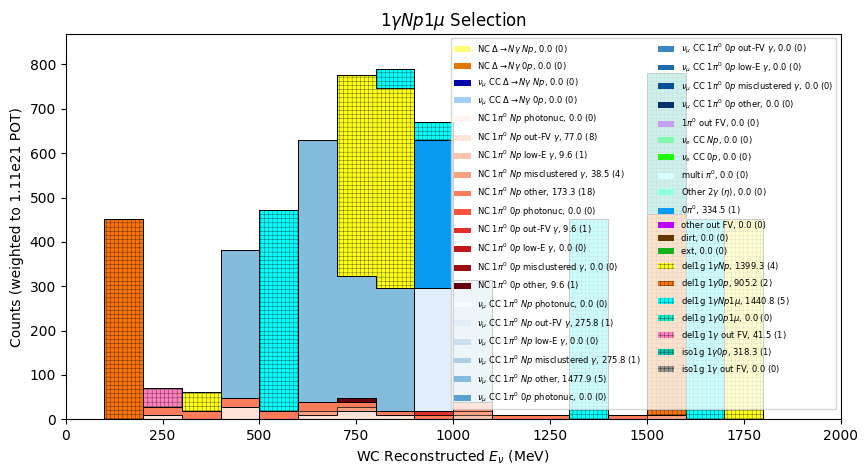

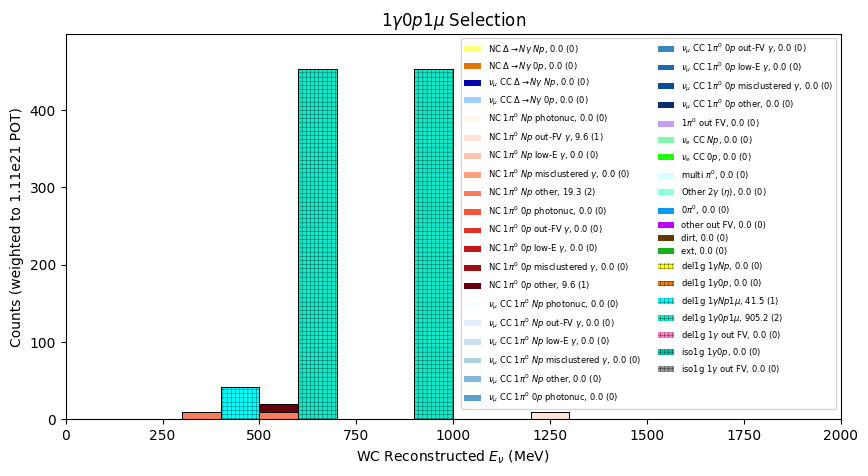

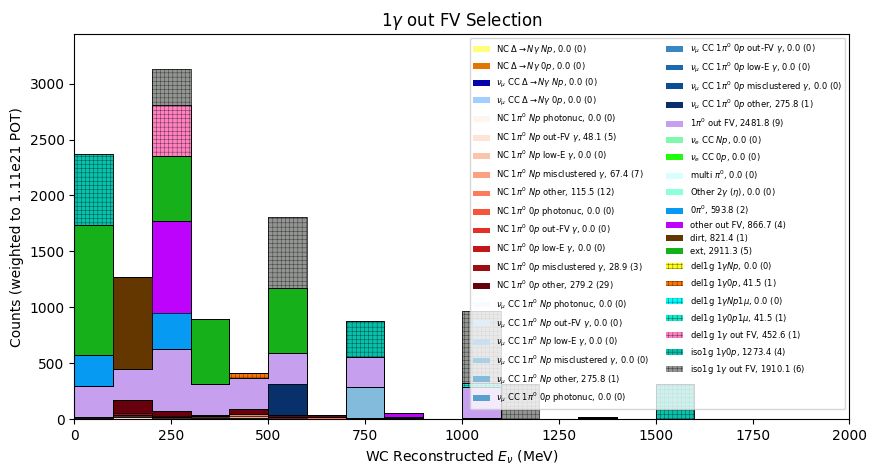

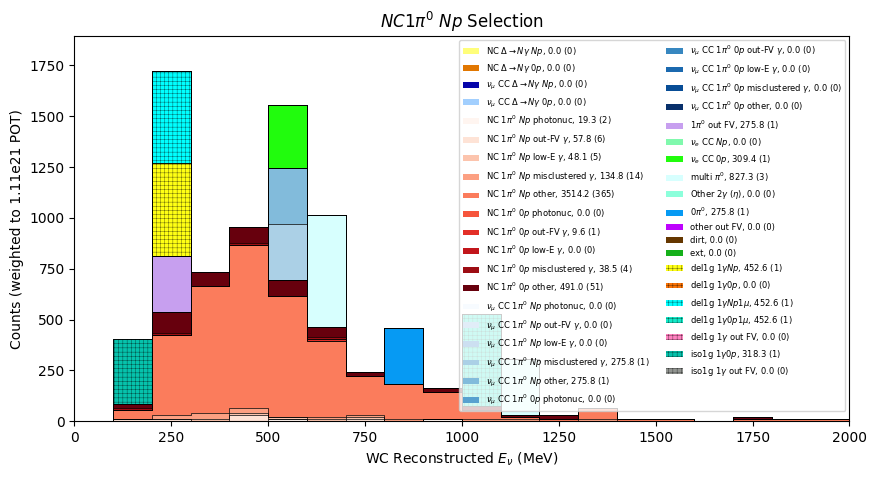

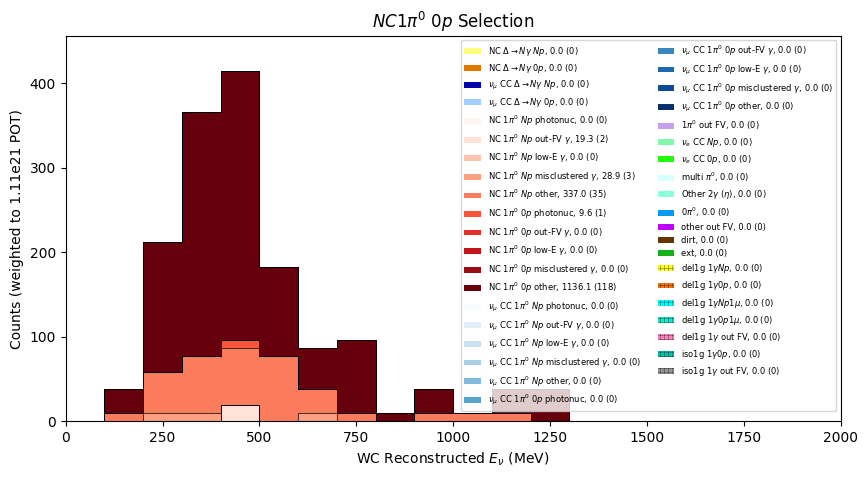

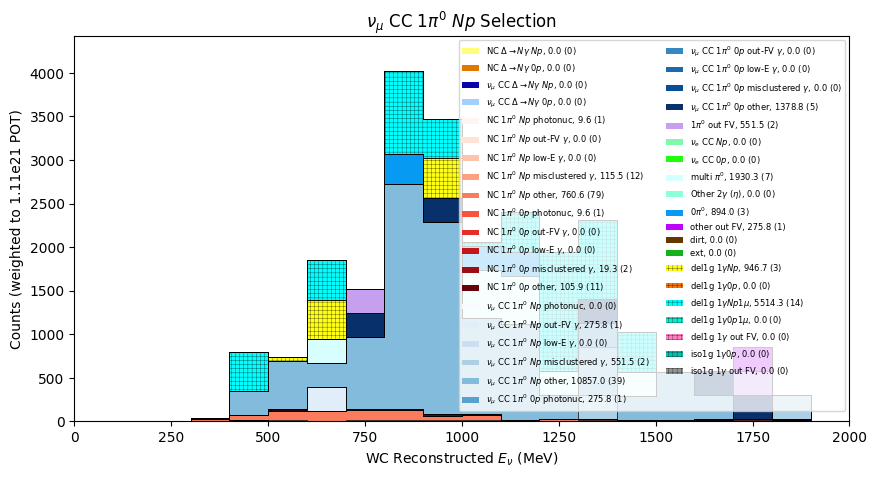

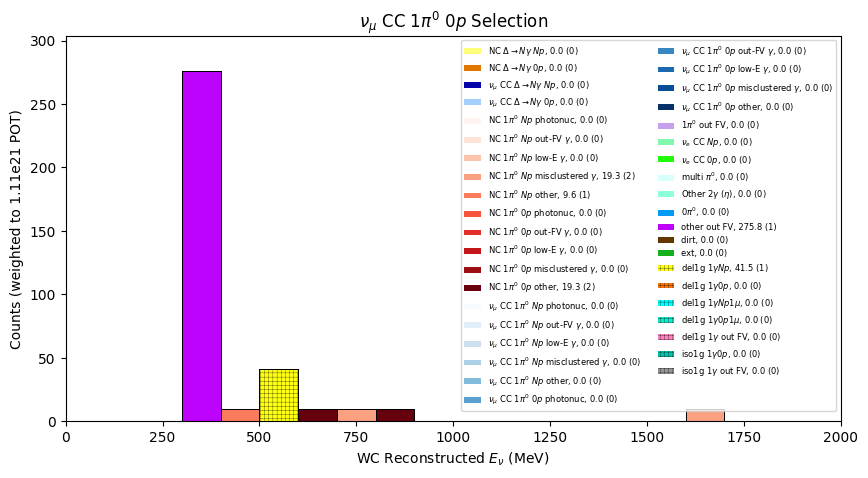

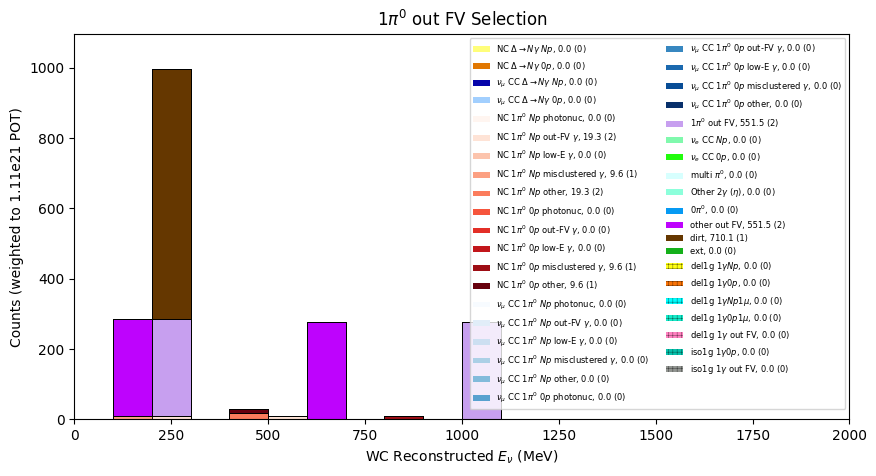

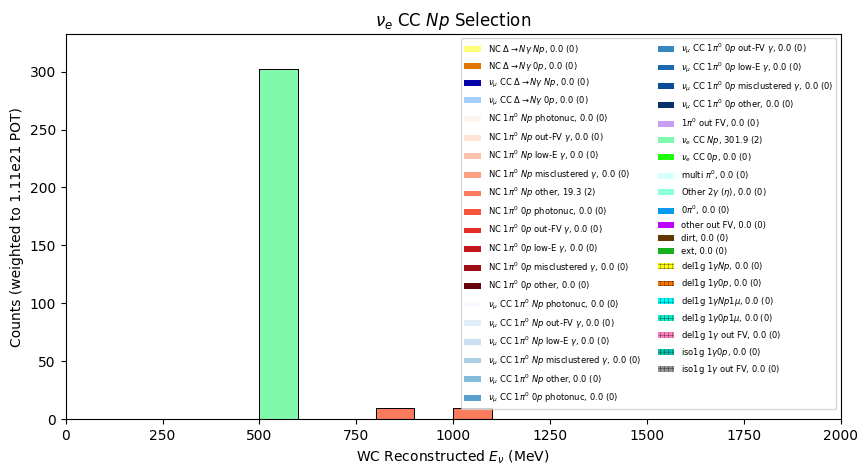

/tmp/ipykernel_3202970/2955836752.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, np.max(bottom) * 1.1)


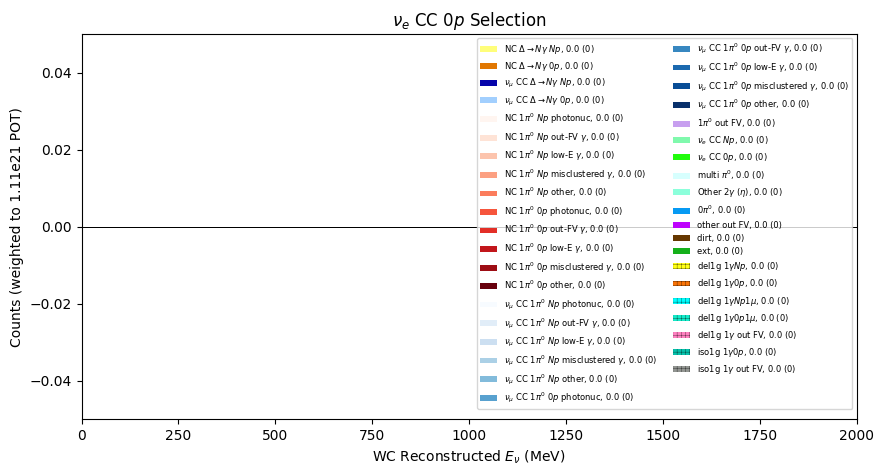

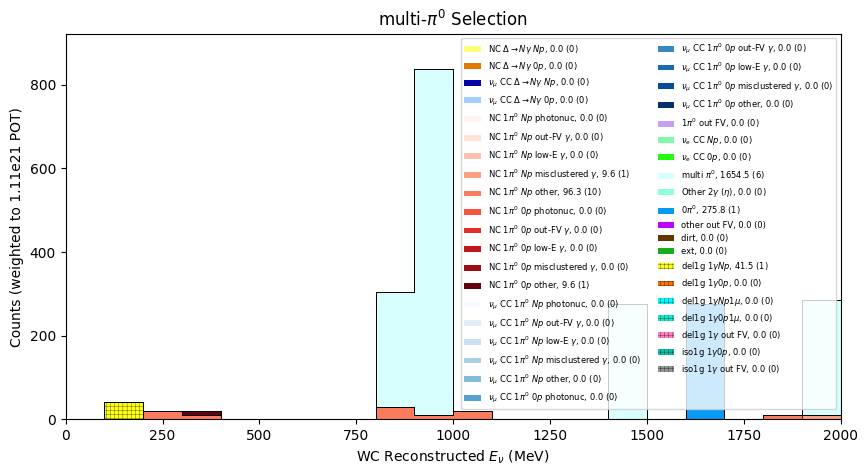

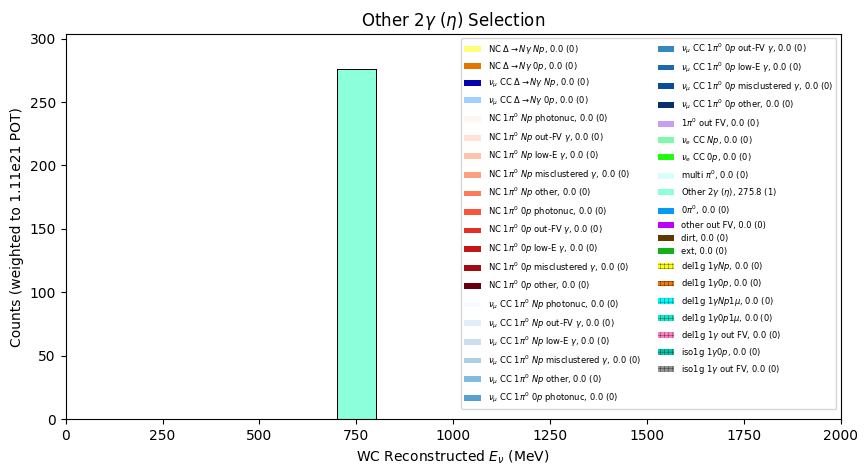

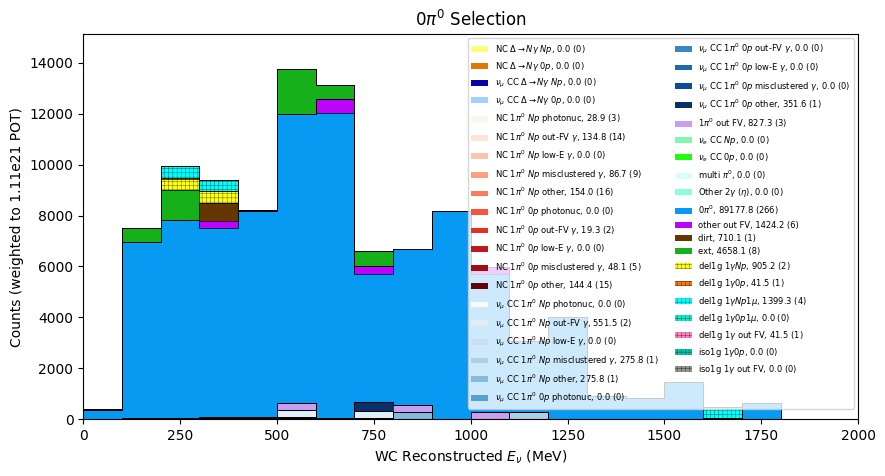

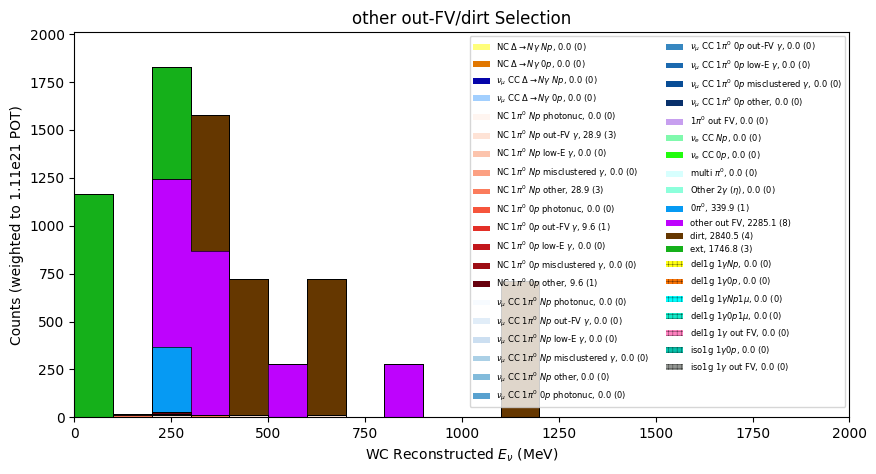

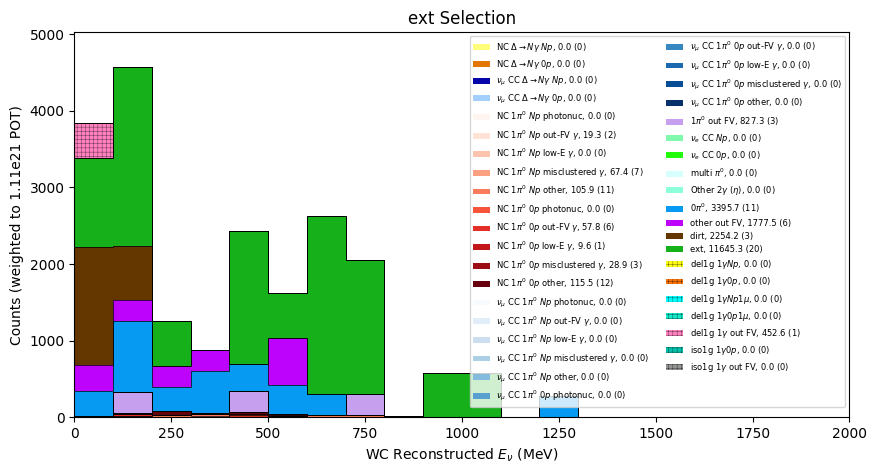

In [7]:
for i in range(len(sig_categories)):
    signal_category = sig_categories[i]
    signal_category_latex = sig_category_labels_latex[i]

    sel_df = presel_merged_df.query(reco_category_queries[i])

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    counts = []
    unweighted_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    fig, ax = plt.subplots(figsize=(10, 5))

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, unweighted_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"


        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    ax.set_ylim(0, np.max(bottom) * 1.1)
    ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    ax.set_ylabel("Counts (weighted to 1.11e21 POT)")
    ax.set_title(f"{signal_category_latex} Selection")
    ax.set_xlim(0, 2000)
    ax.legend(ncol=2, loc='upper right', fontsize=6)

    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}_{signal_category}.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}_{signal_category}.png")
    plt.show()

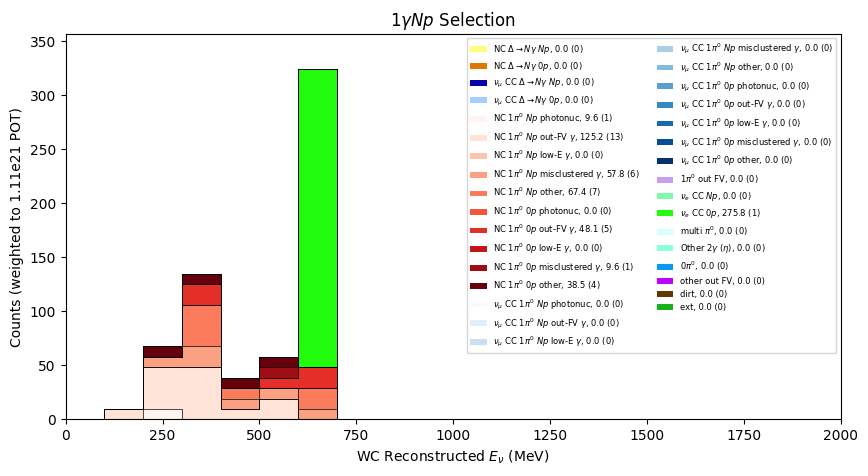

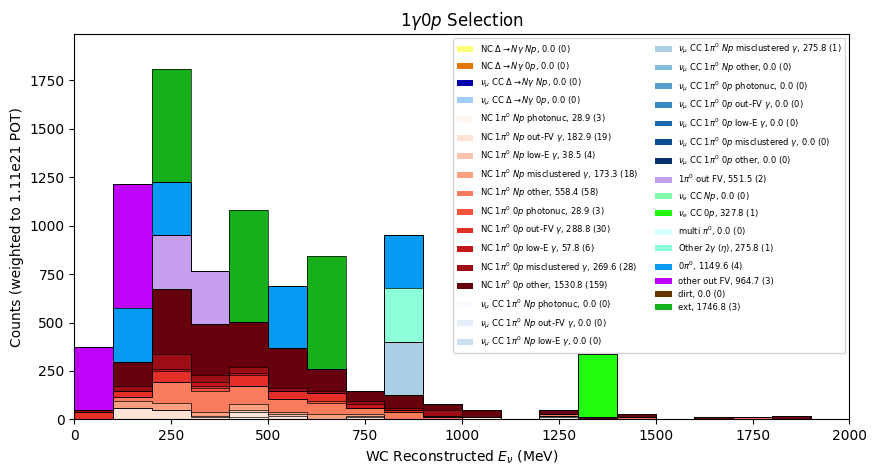

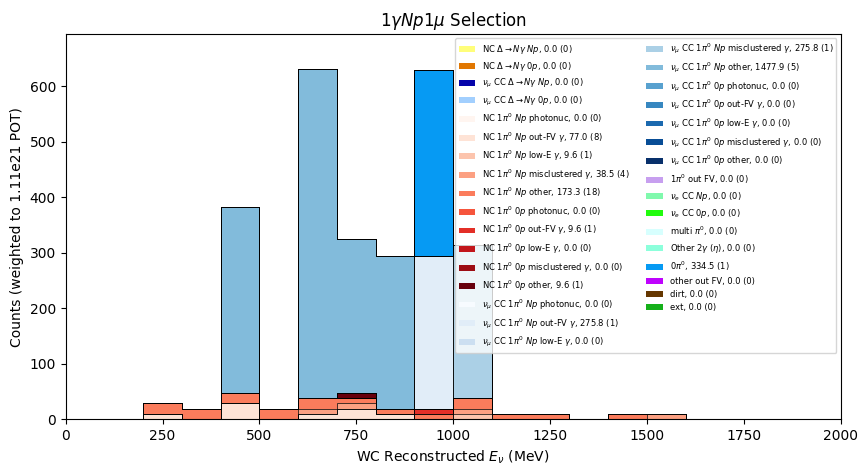

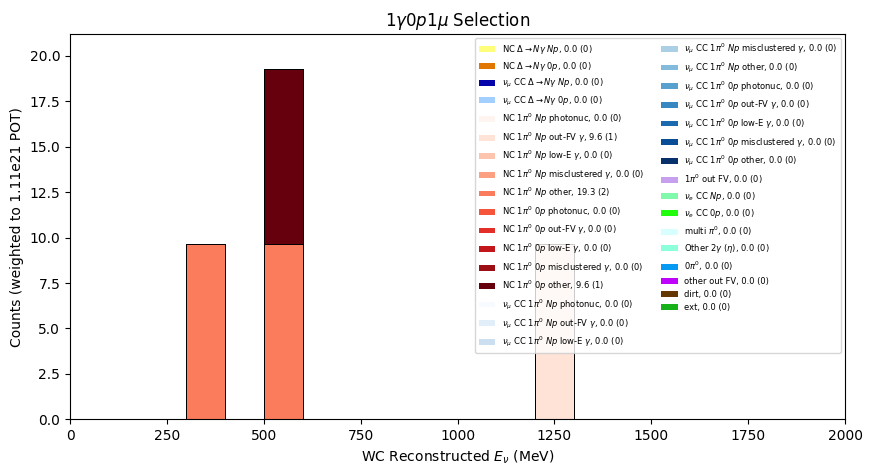

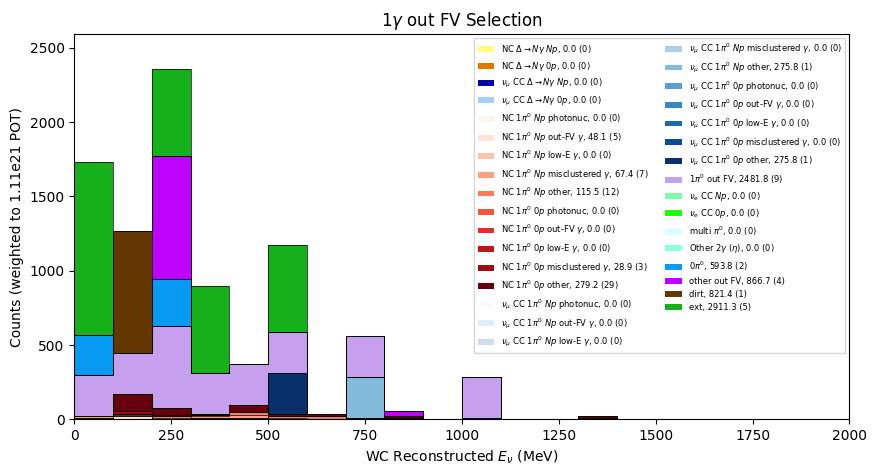

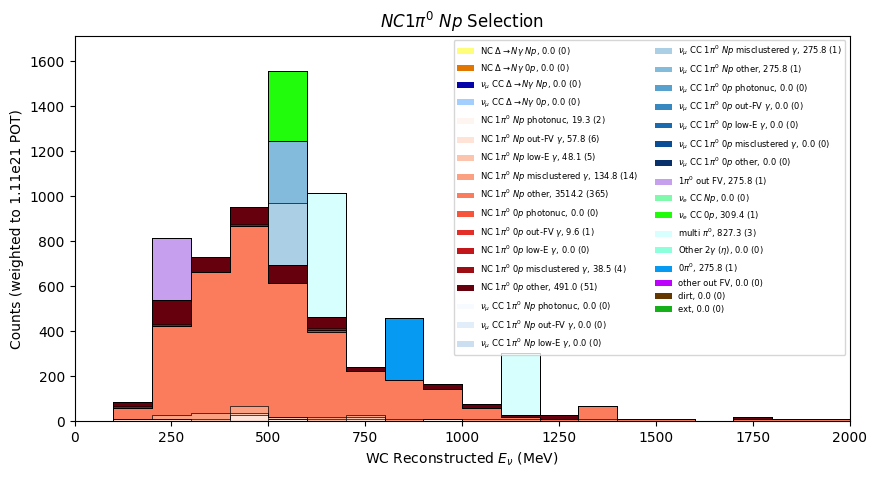

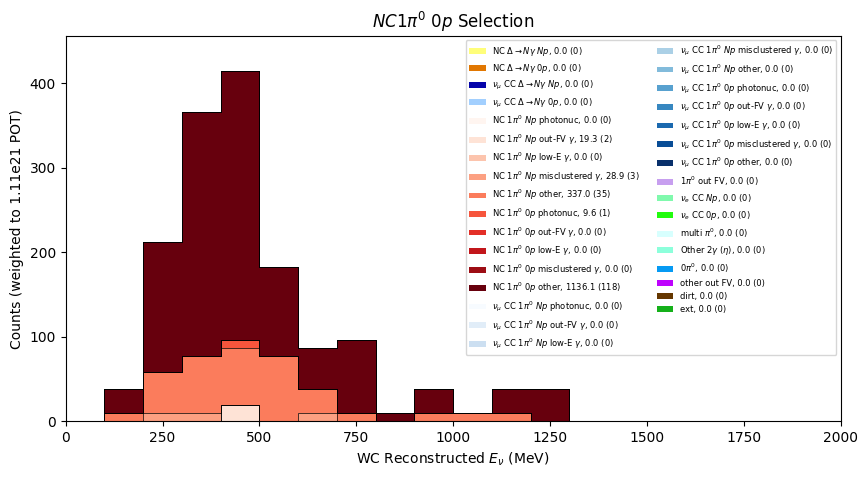

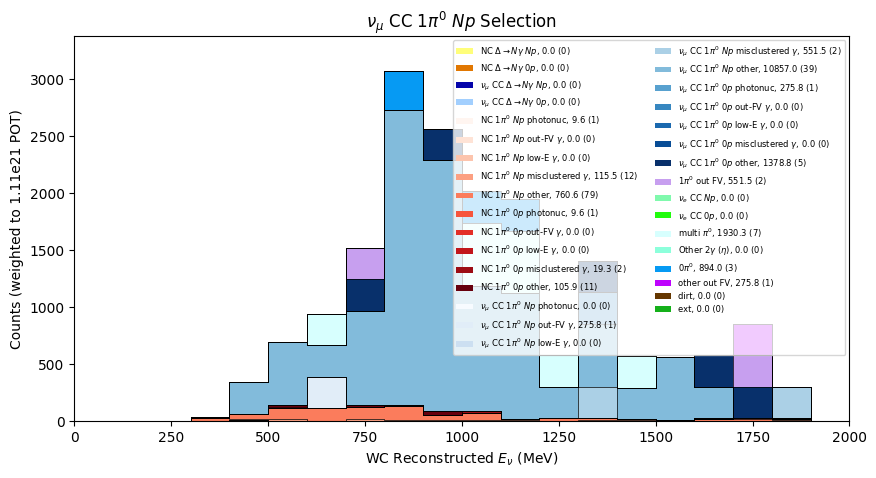

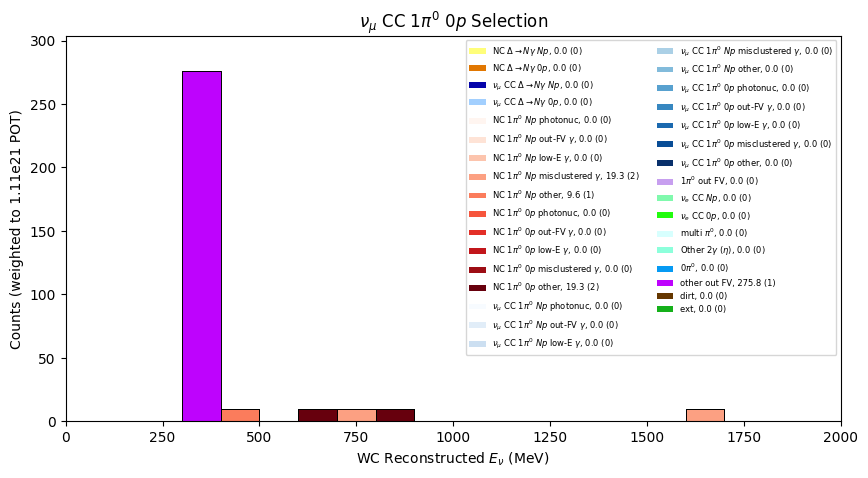

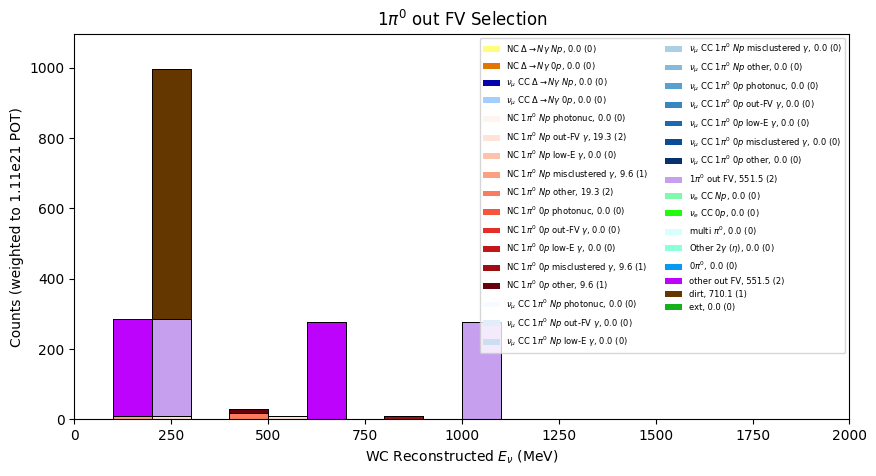

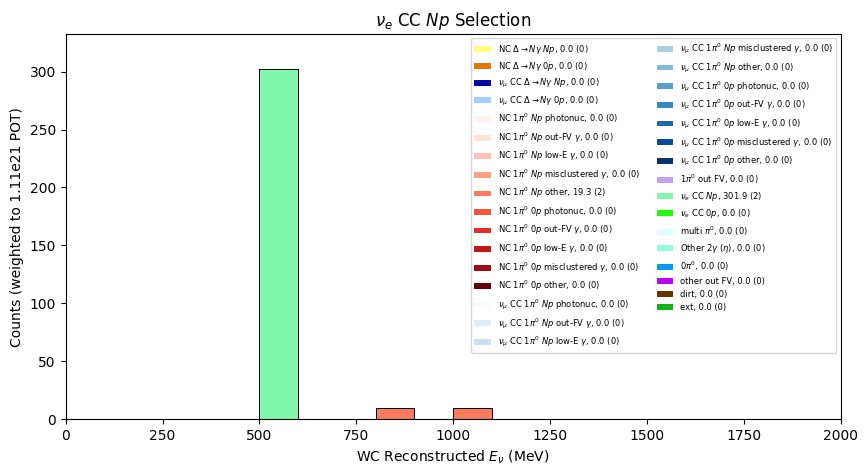

/tmp/ipykernel_3202970/578504517.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, np.max(bottom) * 1.1)


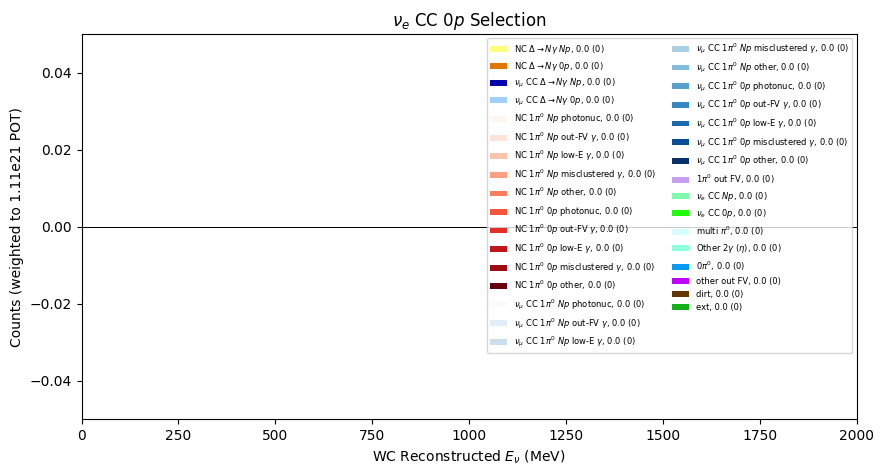

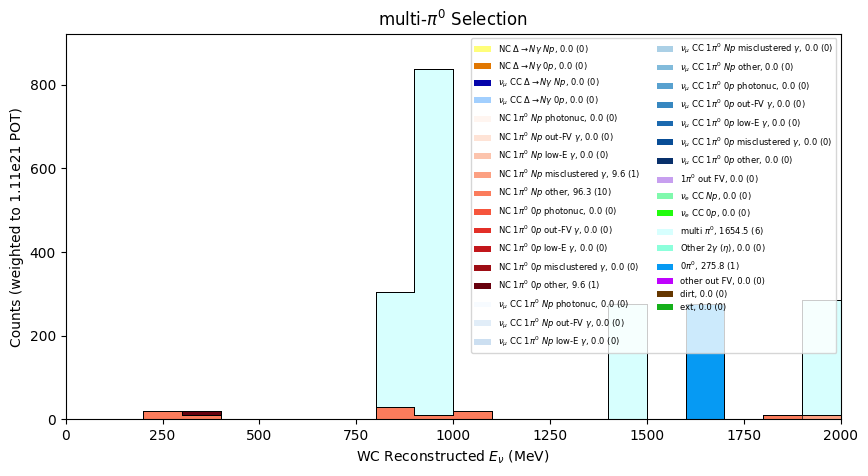

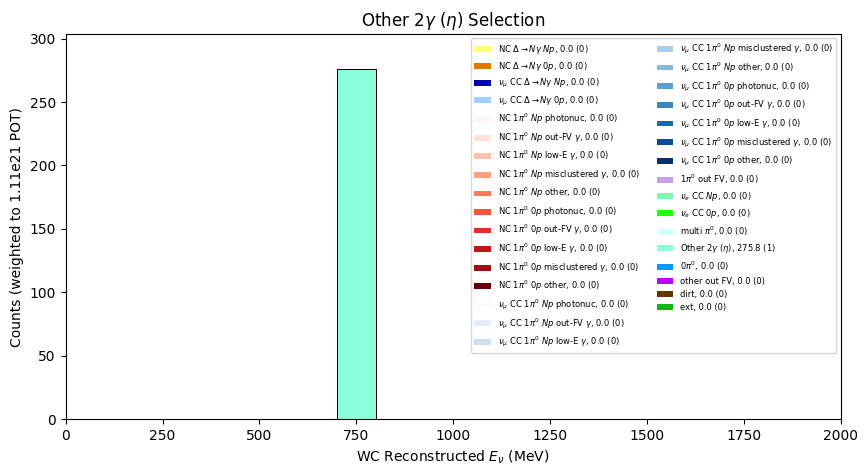

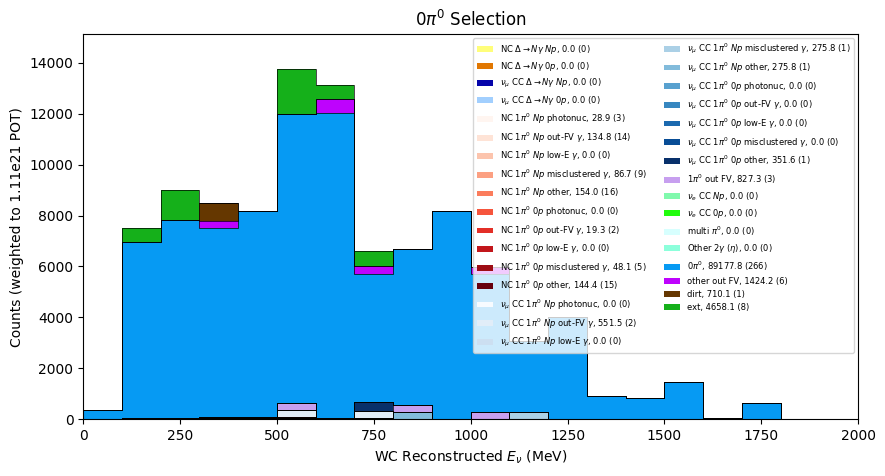

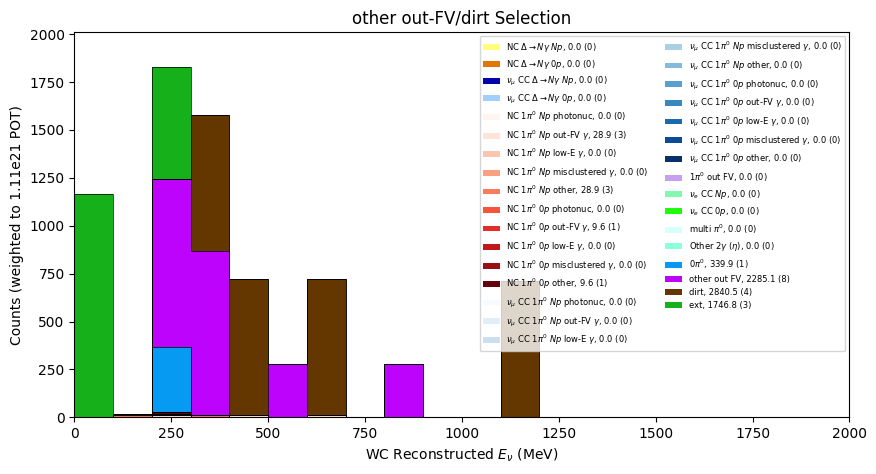

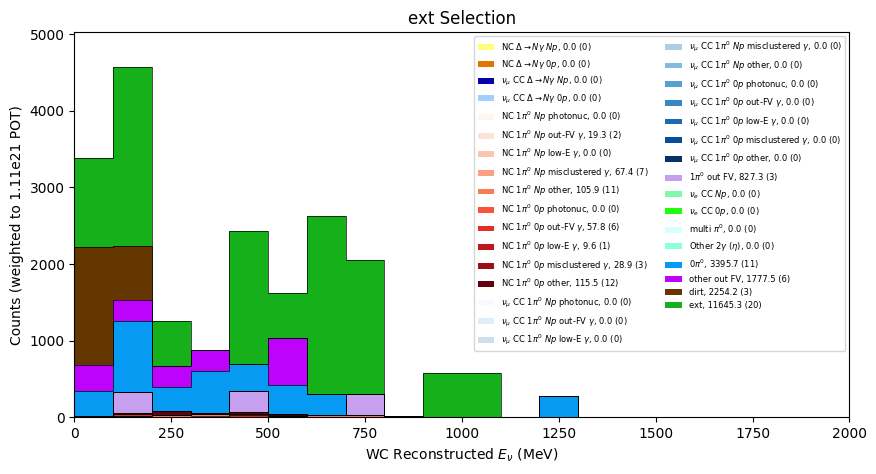

In [8]:
for i in range(len(sig_categories)):
    signal_category = sig_categories[i]
    signal_category_latex = sig_category_labels_latex[i]

    sel_df = presel_merged_df.query(reco_category_queries[i])

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    counts = []
    unweighted_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    fig, ax = plt.subplots(figsize=(10, 5))

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, unweighted_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            continue
        elif "del1g" in breakdown_label:
            continue

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"


        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    ax.set_ylim(0, np.max(bottom) * 1.1)
    ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    ax.set_ylabel("Counts (weighted to 1.11e21 POT)")
    ax.set_title(f"{signal_category_latex} Selection")
    ax.set_xlim(0, 2000)
    ax.legend(ncol=2, loc='upper right', fontsize=6)

    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}_{signal_category}_nosig.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}_{signal_category}_nosig.png")
    plt.show()

# 1g No Signal Different Cut Plots

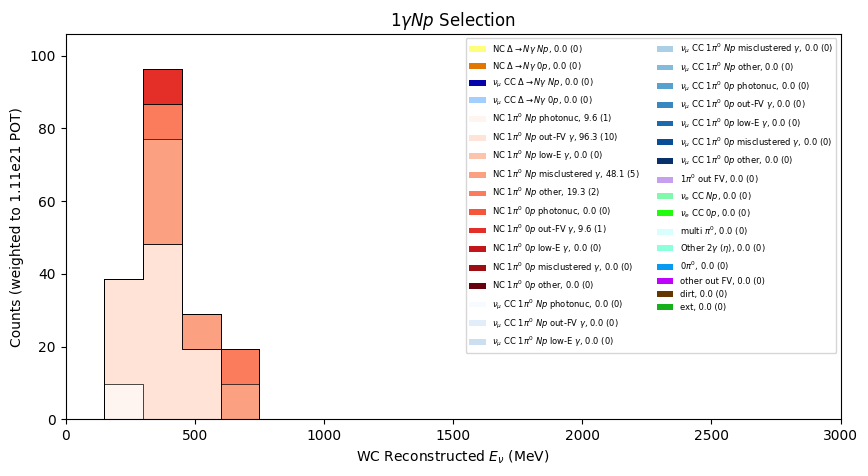

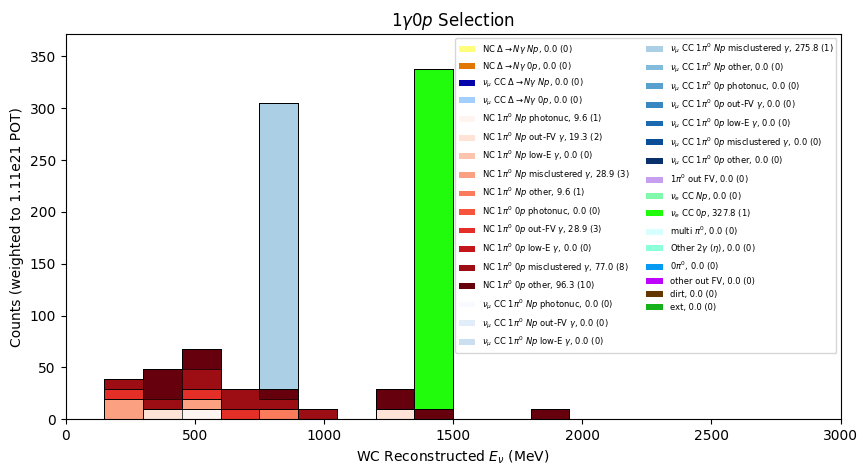

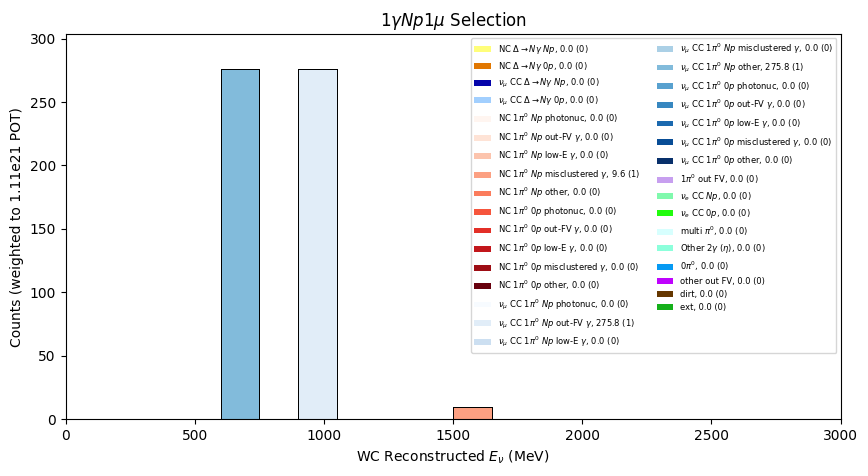

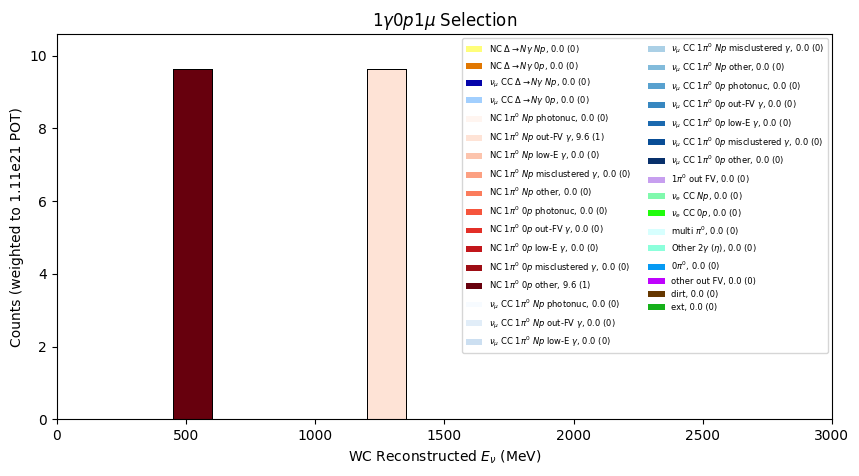

In [9]:
cut_values = [0.5, 0.5, 0.5, 0.5]

refined_1g_queries = [
    "prob_1gNp > 0.5",
    "prob_1g0p > 0.95",
    "prob_1gNp1mu > 0.8",
    "prob_1g0p1mu > 0.3",
]

for i in range(len(sig_categories))[:4]:
    signal_category = sig_categories[i]
    signal_category_latex = sig_category_labels_latex[i]

    sel_df = presel_merged_df.query(refined_1g_queries[i])

    bins = np.linspace(0, 3000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    counts = []
    unweighted_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    fig, ax = plt.subplots(figsize=(10, 5))

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, unweighted_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            continue
        elif "del1g" in breakdown_label:
            continue

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"


        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    ax.set_ylim(0, np.max(bottom) * 1.1)
    ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    ax.set_ylabel("Counts (weighted to 1.11e21 POT)")
    ax.set_title(f"{signal_category_latex} Selection")
    ax.set_xlim(0, 3000)
    ax.legend(ncol=2, loc='upper right', fontsize=6)

    plt.savefig(f"../plots/refined_multiclass_histograms_{training}_{breakdown_type}_{signal_category}_nosig.pdf")
    plt.savefig(f"../plots/refined_multiclass_histograms_{training}_{breakdown_type}_{signal_category}_nosig.png")
    plt.show()

# Checking Event Weights

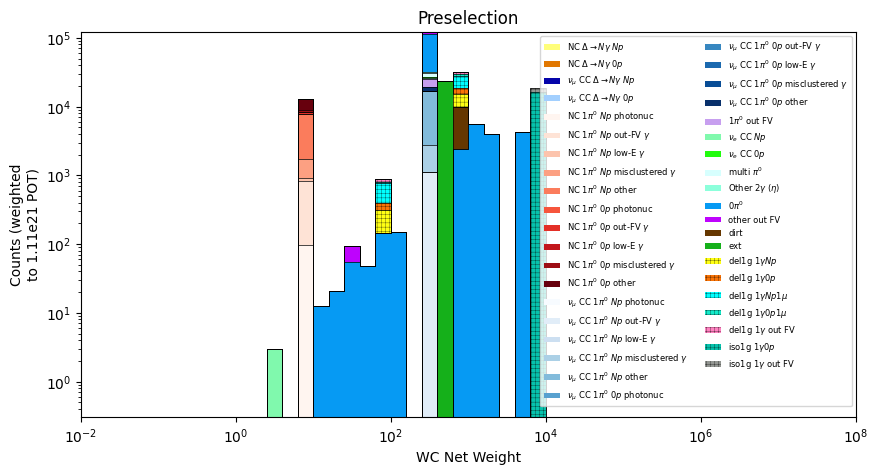

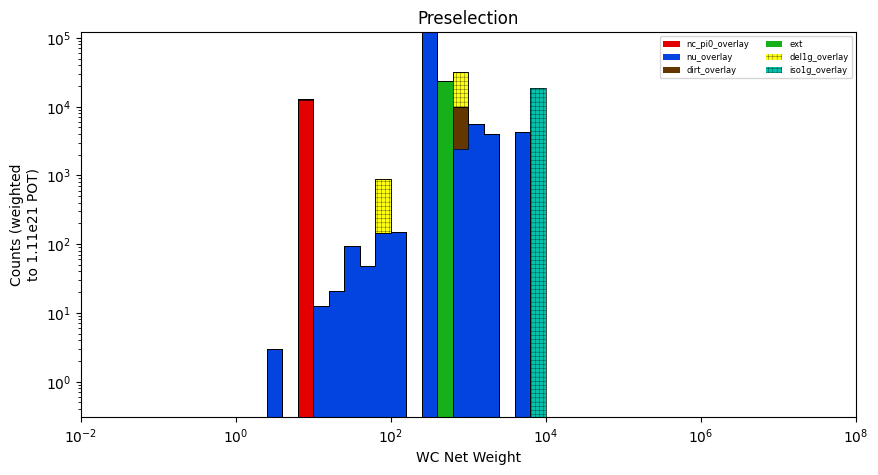

In [19]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

for breakdown_type in ["del1g_detailed", "filetype"]:
    if breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_labels_latex = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_hatches = filetype_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    bins = np.logspace(-2, 8, 51)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    sel_df = presel_merged_df
    counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    plt.xlabel(r"WC Net Weight")
    plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="upper right", ncol=2, fontsize=6)
    plt.title("Preselection")
    plt.show()



# Post-Selection Studies

In [20]:
one_g_reco_category_argmax_indices = []
for i, signal_category in enumerate(sig_categories):
    if "1g" in signal_category:
        one_g_reco_category_argmax_indices.append(i)

combined_1g_query = ""
for i in one_g_reco_category_argmax_indices:
    combined_1g_query += f"reco_category_argmax_index == {i} or "
combined_1g_query = combined_1g_query[:-4]

all_1g_sel_df = presel_merged_df.query(combined_1g_query)

print(f"{presel_merged_df.shape=}")
print(f"{all_1g_sel_df.shape=}")

presel_merged_df.shape=(1946, 271)
all_1g_sel_df.shape=(604, 271)


## Blip Veto

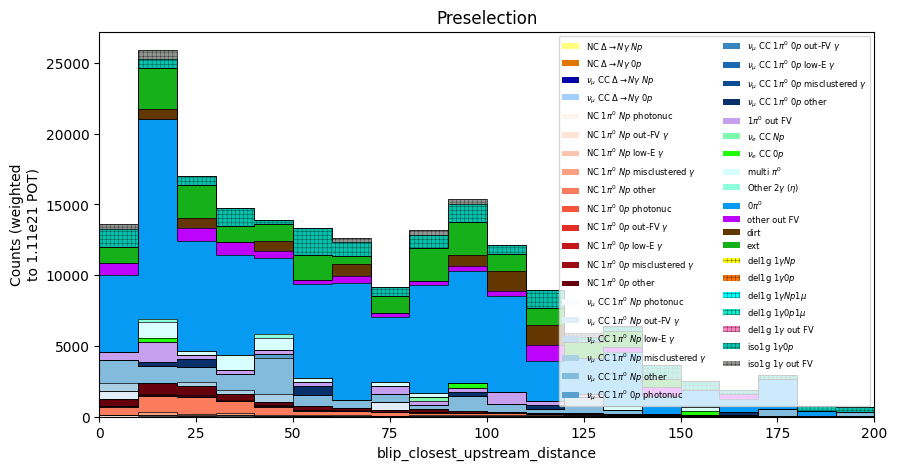

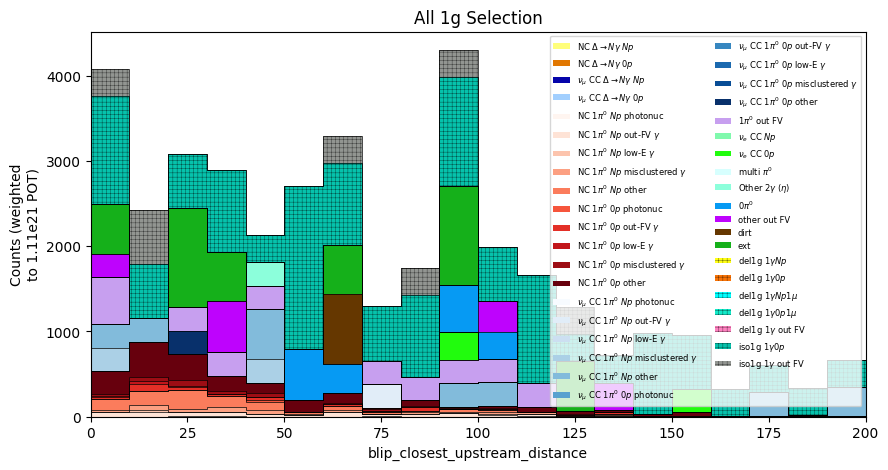

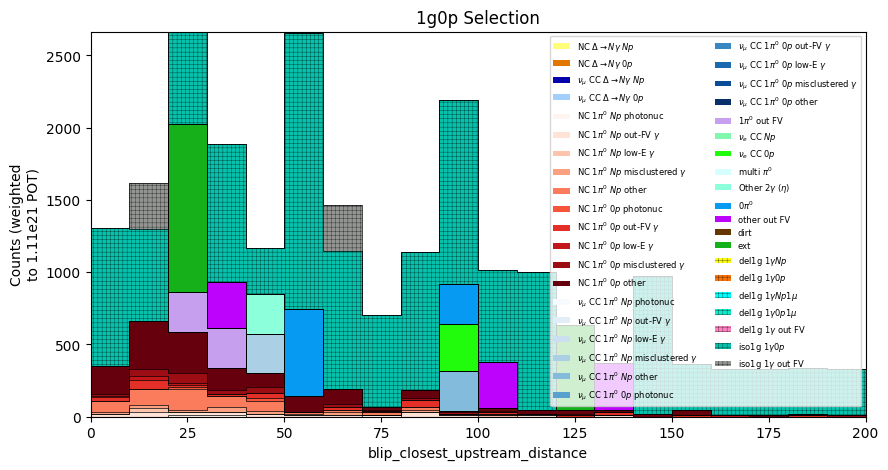

In [22]:
del1g_norm_factor = 0
iso1g_norm_factor = 0.05

for breakdown_type in ["del1g_detailed"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    for sel_type in ["presel", "all_1g", "1g0p"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df
        elif sel_type == "1g0p":
            sel_df = presel_merged_df.query("reco_category_argmax_index == 1")
                
        blip_postprocessing_vars_bin_ranges = [
            ("blip_closest_upstream_distance", 0, 200),
            #("blip_closest_upstream_angle", 0, 90),
            #("blip_closest_upstream_impact_parameter", 0, 200),
            #("blip_closest_upstream_energy", 0, 20),
            #("blip_closest_upstream_dx", 0, 5),
            #("blip_closest_upstream_dw", 0, 5),
        ]

        for var, min_val, max_val in blip_postprocessing_vars_bin_ranges:

            plt.figure(figsize=(10, 5))
            ax = plt.gca()
            bins = np.linspace(min_val, max_val, 21)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            multi_bin_centers = [bin_centers] * len(breakdown_labels)
            outline_colors = ["k"] * len(breakdown_labels)
            counts = []
            for breakdown_i, breakdown_label in enumerate(breakdown_labels):
                curr_df = sel_df.query(breakdown_queries[breakdown_i])
                counts.append(np.histogram(curr_df[var].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
            
            bottom = np.zeros(len(bins)-1)
            for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
                if "iso1g" in breakdown_label:
                    breakdown_count = breakdown_count * iso1g_norm_factor
                elif "del1g" in breakdown_label:
                    breakdown_count = breakdown_count * del1g_norm_factor
                n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
                ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
                if breakdown_i == 0:
                    bottom = n
                else:
                    bottom += n

            plt.xlabel(var)
            plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
            plt.xlim(bins[0], bins[-1])
            plt.legend(loc="upper right", ncol=2, fontsize=6)
            if sel_type == "presel":
                plt.title(f"Preselection")
            elif sel_type == "1g0p":
                plt.title(f"1g0p Selection")
            elif sel_type == "all_1g":
                plt.title(f"All 1g Selection")

            plt.show()


## Nanosecond Timing

In [23]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

# related to https://github.com/brb-rightback/ns_demo_MCC9.10/blob/main/ns_demo_MCC9.10.ipynb
# TODO: Validate this with data and showers, see https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=44781
# Also check the manually applied shifts for all the different time periods

data_presel_merged_df = presel_merged_df.query("filetype == 'data' or filetype == 'ext'")
mc_presel_merged_df = presel_merged_df.query("not (filetype == 'data' or filetype == 'ext')")

data_presel_merged_df["non_merge_time"] = data_presel_merged_df["wc_evtTimeNS"]
mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data

run = data_presel_merged_df["run"].to_numpy()
evtTimeNS = data_presel_merged_df["wc_evtTimeNS"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.5 
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    if np.isinf(TThelp):
        TThelp = np.nan
    TT_merged = -9999.
    if(TThelp>=0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
data_presel_merged_df["merge_time"] = new_times

evtTimeNS = mc_presel_merged_df["wc_evtTimeNS_cor"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=5.8-0.3
    TThelp=0
    TThelp = np.nan_to_num(evtTimeNS[i]-Shift+gap*0.5,nan=-9999)
    TT_merged = -9999.
    if(TThelp>=0):
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
mc_presel_merged_df["merge_time"] = new_times

presel_merged_df = pd.concat([data_presel_merged_df, mc_presel_merged_df])
all_1g_sel_df = presel_merged_df.query(combined_1g_query)


/tmp/ipykernel_3202970/1561817919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_presel_merged_df["non_merge_time"] = data_presel_merged_df["wc_evtTimeNS"]
/tmp/ipykernel_3202970/1561817919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data
/tmp/ipykernel_3202970/1561817919.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

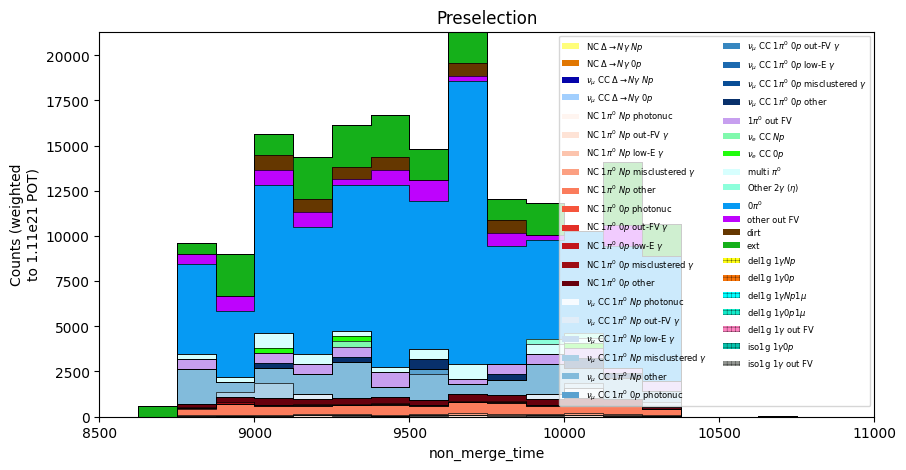

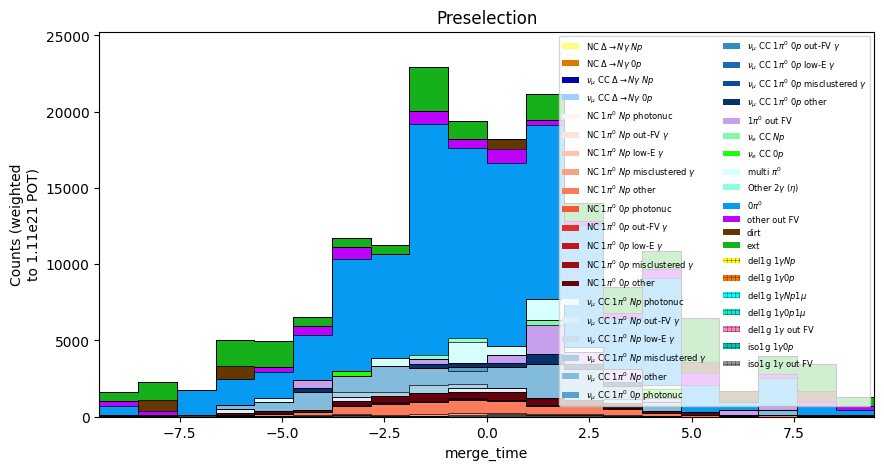

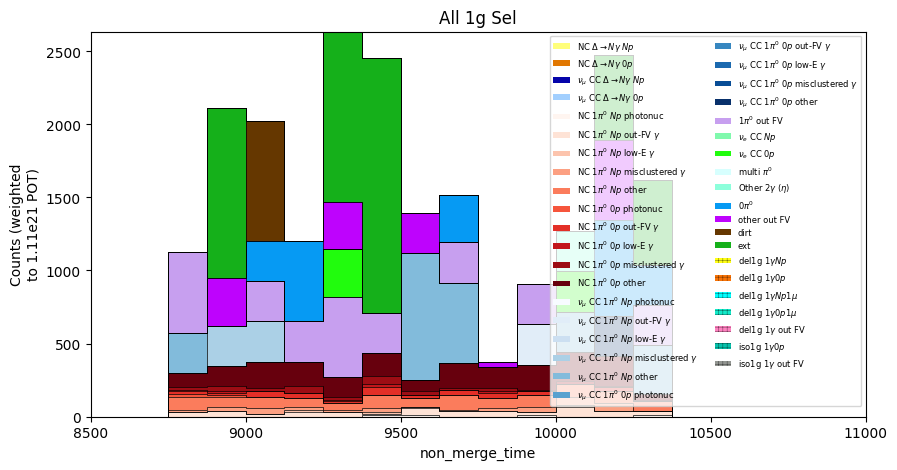

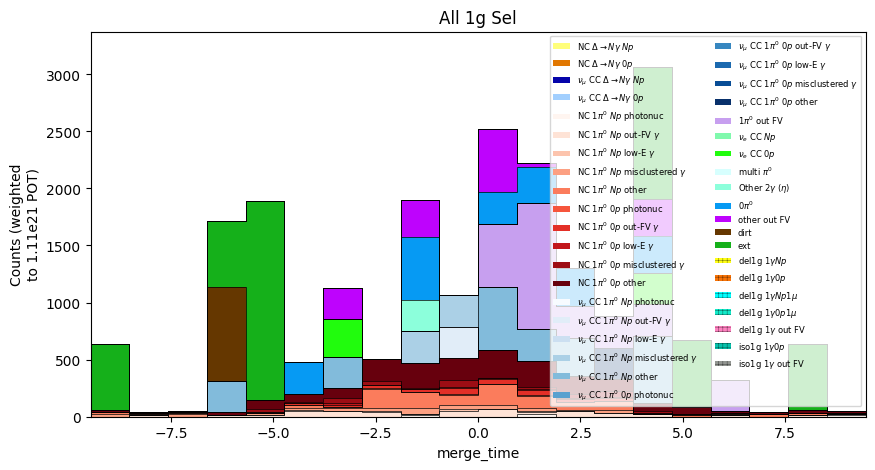

In [24]:
for breakdown_type in ["del1g_detailed"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df


        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(8500, 11000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["non_merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        plt.xlabel("non_merge_time")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=6)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(-9.462531250000058, 9.462531250000058, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        plt.ylim(0, np.max(bottom) * 1.1)

        plt.xlabel("merge_time")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=6)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


## Out-TPC PMT Veto

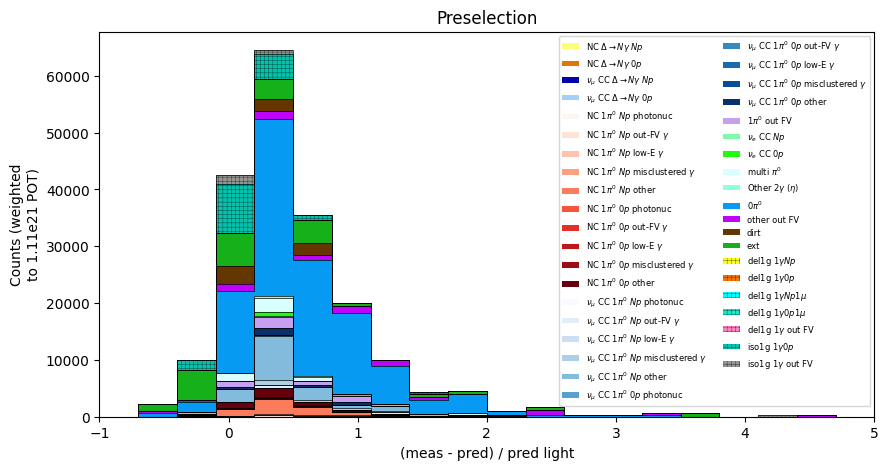

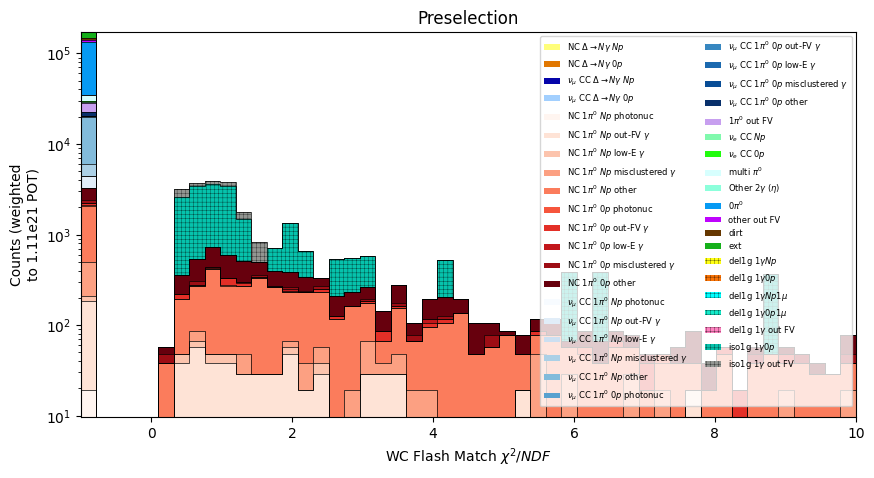

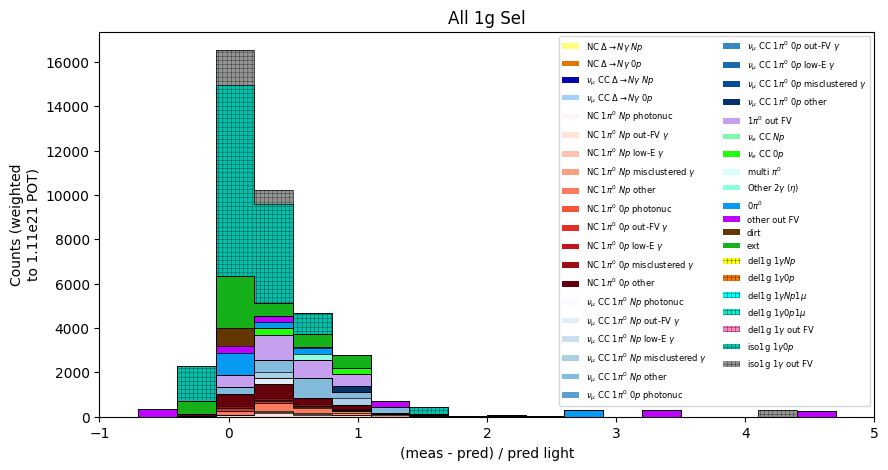

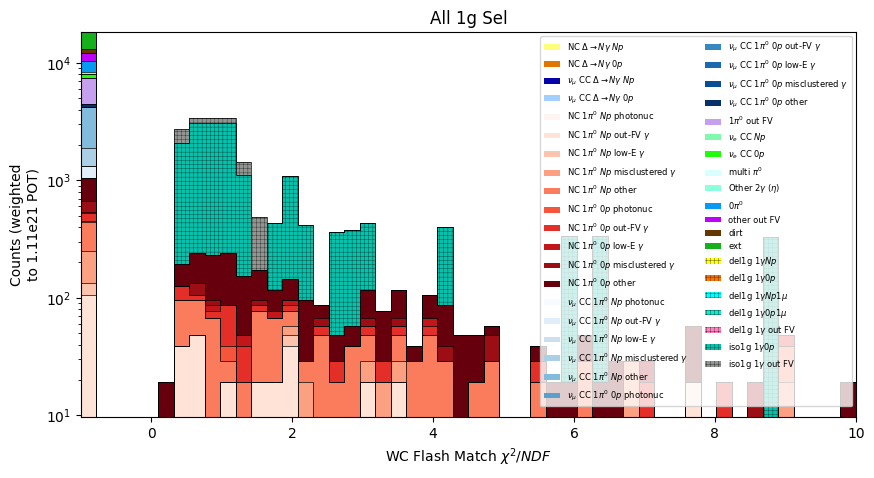

In [25]:
# TODO: Add more detailed PMT-by-PMT information, see https://github.com/kpulido444/REU_uboone_photon_rejection
# Could require SUPRPRISE files with newer WC PMT info

del1g_norm_factor = 0
iso1g_norm_factor = 0.05

print("WARNING: Missing detailed PMT Information for run 4b v10_04_07_09 files, for these missing file information we set chi2/ndf to -1!")

for breakdown_type in ["del1g_detailed"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df

        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(-1, 5, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            ratio = (curr_df["wc_flash_measPe"].to_numpy() - curr_df["wc_flash_predPe"].to_numpy()) / curr_df["wc_flash_predPe"].to_numpy()
            counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n
        plt.xlabel("(meas - pred) / pred light")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=6)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()

        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(-1, 10, 51)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            ratio = curr_df["wc_WCPMTInfoChi2"].to_numpy() / curr_df["wc_WCPMTInfoNDF"].to_numpy()
            ratio = np.nan_to_num(ratio, nan=-1, posinf=-1, neginf=-1)
            counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n
        plt.xlabel(r"WC Flash Match $\chi^2 / NDF$")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=6)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.yscale("log")
        plt.show()


## Out-TPC CRT Veto

In [26]:
# TODO: Look at CRT information, and if we can identify in-time out-TPC activity associated with an event
# (even if there's no clean CRT track indicating a through-going cosmic muon)


# Out-TPC Geometric BDT

In [27]:
# TODO: Look at just shower position and direction, use that to separate in-FV vs out-FV reco-1g events


## Spacepoint SSV

In [28]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on
